In [1]:
from dask.distributed import Client,LocalCluster
import xarray as xr
import dask
import glob
import geopandas as gpd
import rioxarray as rio
import shapely

In [2]:
data_dir=r'C://Users/kerrie/Documents/02_LocalData/nclimgrid_daily/'
shpfile=r'C://Users/kerrie/Documents/02_LocalData/boundaries/study_area_bounding_box.shp'

In [ ]:
# this may require adjustment on other computers
# my computer has 32GB RAM and 20 threads

# nworkers=20  # set equal to number of threads you have
# cluster=LocalCluster(n_workers=nworkers,threads_per_worker=1)
# client=Client(cluster) 
# client

## Data Cleaning

1) drop any variables we don't need
2) dim names are time, lat, lon
3) time is correct datetimes
4) lat is ascending
5) lon is ascending -180 to 180
6) variable names tmax,tmin,prcp
7) units of C for temperature
8) units of mm/day for precip
9) spatial subset
11) round all values to 2 decimal places
12) save data with smallest possible precision
13) write cleaned files, 1 file per variable


In [3]:
files=sorted(glob.glob(data_dir+'orig/ncdd*-grd-scaled.nc'))
len(files), files[0:3]

(884,
 ['C://Users/kerrie/Documents/02_LocalData/nclimgrid_daily/orig\\ncdd-195101-grd-scaled.nc',
  'C://Users/kerrie/Documents/02_LocalData/nclimgrid_daily/orig\\ncdd-195102-grd-scaled.nc',
  'C://Users/kerrie/Documents/02_LocalData/nclimgrid_daily/orig\\ncdd-195103-grd-scaled.nc'])

In [4]:
# lazy dataset, all 800+ files
ds=xr.open_mfdataset(files,chunks='auto',lock=False)
ds

<xarray.Dataset> Size: 711GB
Dimensions:  (time: 26907, lat: 596, lon: 1385)
Coordinates:
  * time     (time) datetime64[ns] 215kB 1951-01-01 1951-01-02 ... 2024-08-31
  * lat      (lat) float32 2kB 24.56 24.6 24.65 24.69 ... 49.27 49.31 49.35
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02
Data variables:
    tmax     (time, lat, lon) float64 178GB dask.array<chunksize=(20, 596, 1385), meta=np.ndarray>
    tmin     (time, lat, lon) float64 178GB dask.array<chunksize=(20, 596, 1385), meta=np.ndarray>
    prcp     (time, lat, lon) float64 178GB dask.array<chunksize=(20, 596, 1385), meta=np.ndarray>
    tavg     (time, lat, lon) float64 178GB dask.array<chunksize=(20, 596, 1385), meta=np.ndarray>
Attributes: (12/33)
    date_created:               2022-08-27 17:20:14.814647
    date_modified:              2022-08-27 17:20:14.815683
    Conventions:                CF-1.7, ACDD-1.3
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    title:                      nClimGrid-Daily, Gridded Fields
    source:                     GHCN-Daily, nClimGrid-Monthly
    ...                         ...
    time_coverage_start:        1951-01-01
    time_coverage_end:          1951-01-31
    program:                    Center for Weather and Climate/Climate Scienc...
    geospatial_lat_resolution:  0.04167 degrees
    geospatial_lon_resolution:  0.04167 degrees
    platform:                   station

In [5]:
# 1) drop data we don't need"
ds = ds.drop_vars('tavg')

steps 2-7 aren't necessary, data already looks good wrt to these items

In [6]:
# step 8 millimeter --> mm/day
ds.prcp.attrs['units']='mm/day'

In [7]:
# step 9 spatial subset
# clip data to a bounding box

# get clip object
box=gpd.read_file(shpfile)

# assign crs to netcdf data
ds.rio.write_crs("epsg:4326",inplace=True)
ds_clip=ds.rio.clip(box.geometry.apply(shapely.geometry.mapping),box.crs,drop=True,invert=False)
ds_clip

Cannot find header.dxf (GDAL_DATA is not defined)


<xarray.Dataset> Size: 174GB
Dimensions:      (time: 26907, lat: 358, lon: 753)
Coordinates:
  * time         (time) datetime64[ns] 215kB 1951-01-01 ... 2024-08-31
  * lat          (lat) float32 1kB 24.56 24.6 24.65 24.69 ... 39.35 39.4 39.44
  * lon          (lon) float32 3kB -106.6 -106.6 -106.5 ... -75.35 -75.31 -75.27
    spatial_ref  int32 4B 0
Data variables:
    tmax         (time, lat, lon) float64 58GB dask.array<chunksize=(20, 358, 753), meta=np.ndarray>
    tmin         (time, lat, lon) float64 58GB dask.array<chunksize=(20, 358, 753), meta=np.ndarray>
    prcp         (time, lat, lon) float64 58GB dask.array<chunksize=(20, 358, 753), meta=np.ndarray>
Attributes: (12/33)
    date_created:               2022-08-27 17:20:14.814647
    date_modified:              2022-08-27 17:20:14.815683
    Conventions:                CF-1.7, ACDD-1.3
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    title:                      nClimGrid-Daily, Gridded Fields
    source:                     GHCN-Daily, nClimGrid-Monthly
    ...                         ...
    time_coverage_start:        1951-01-01
    time_coverage_end:          1951-01-31
    program:                    Center for Weather and Climate/Climate Scienc...
    geospatial_lat_resolution:  0.04167 degrees
    geospatial_lon_resolution:  0.04167 degrees
    platform:                   station

step 10 & 11, round and reduce precision

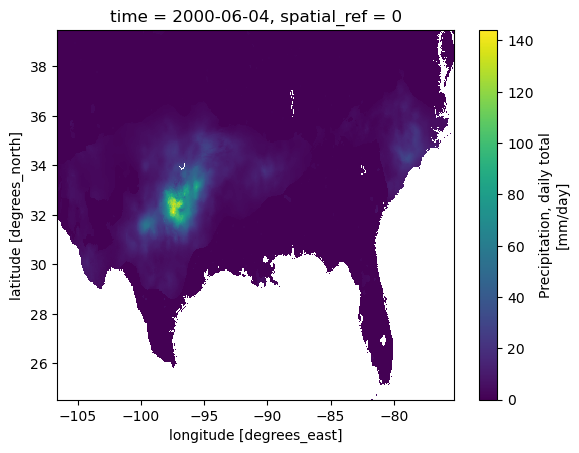

In [33]:
# choosing a single time to test data precision, looking for values on order of at least 100
testtime='2000-06-4'
ds_clip.prcp.sel(time=testtime).plot()

In [34]:
# float16 is probably not enough precision, let's check on a subset of the data

print('loading float16')
prcp_16 = ds_clip.prcp.sel(time=testtime).astype('float16').load()
print('loading float32')
prcp_32 = ds_clip.prcp.sel(time=testtime).astype('float32').load()
print('loading float64')
prcp_64 = ds_clip.prcp.sel(time=testtime).load()

prcp_16.max().item(),prcp_32.max().item(),prcp_64.max().item()

loading float16
loading float32
loading float64


(144.125, 144.078125, 144.078125)

so we can change the data type from float64 to float32 but not go any smaller

In [35]:
# steps 10 & 11
ds = ds_clip.round(decimals=2)
ds = ds_clip.astype('float32')
ds

<xarray.Dataset> Size: 87GB
Dimensions:      (time: 26907, lat: 358, lon: 753)
Coordinates:
  * time         (time) datetime64[ns] 215kB 1951-01-01 ... 2024-08-31
  * lat          (lat) float32 1kB 24.56 24.6 24.65 24.69 ... 39.35 39.4 39.44
  * lon          (lon) float32 3kB -106.6 -106.6 -106.5 ... -75.35 -75.31 -75.27
    spatial_ref  int32 4B 0
Data variables:
    tmax         (time, lat, lon) float32 29GB dask.array<chunksize=(20, 358, 753), meta=np.ndarray>
    tmin         (time, lat, lon) float32 29GB dask.array<chunksize=(20, 358, 753), meta=np.ndarray>
    prcp         (time, lat, lon) float32 29GB dask.array<chunksize=(20, 358, 753), meta=np.ndarray>
Attributes: (12/33)
    date_created:               2022-08-27 17:20:14.814647
    date_modified:              2022-08-27 17:20:14.815683
    Conventions:                CF-1.7, ACDD-1.3
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    title:                      nClimGrid-Daily, Gridded Fields
    source:                     GHCN-Daily, nClimGrid-Monthly
    ...                         ...
    time_coverage_start:        1951-01-01
    time_coverage_end:          1951-01-31
    program:                    Center for Weather and Climate/Climate Scienc...
    geospatial_lat_resolution:  0.04167 degrees
    geospatial_lon_resolution:  0.04167 degrees
    platform:                   station

# write files

In [ ]:
%%time
filename='prcp_nClimGridDaily_1951-2024_south.nc'
print('writing',filename)
ds.prcp.to_netcdf(data_dir+filename)

In [ ]:
%%time
filename='tmax_nClimGridDaily_1951-2024_south.nc'
print('writing',filename)
ds.tmax.to_netcdf(data_dir+filename)

In [ ]:
%%time
filename='tmin_nClimGridDaily_1951-2024_south.nc'
print('writing',filename)
ds.tmin.to_netcdf(data_dir+filename)

In [ ]:
test=xr.open_mfdataset(data_dir+filename)
test

In [ ]:
client.shutdown()